# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
<ipython-input-2-c303507f1168>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [4]:
samsung_train_df = samsung_df[:317]
samsung_train_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-07,85600.0
2021-04-08,84700.0
2021-04-09,83600.0


In [5]:
samsung_test_df = samsung_df[317:]
samsung_test_df

,price
day,
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0
2021-04-19,83300.0
2021-04-20,83900.0


In [6]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# samsung_train_df.price.values에 대해 ARIMA 모델을 학습한다.
# (AR = 2, 차분 = 1, MA = 2) 파라미터 사용
model = ARIMA(samsung_train_df.price.values, order=(2, 1, 2))
model_fit = model.fit()

# 모델 요약 출력
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  317
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2696.573
Date:                Tue, 27 Feb 2024   AIC                           5403.147
Time:                        13:49:08   BIC                           5421.925
Sample:                             0   HQIC                          5410.649
                                - 317                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0700      2.009      0.035      0.972      -3.867       4.007
ar.L2          0.7255      1.795      0.404      0.686      -2.792       4.243
ma.L1         -0.0566      2.031     -0.028      0.9

<Axes: title={'center': 'Residual between GT and Estimation'}>

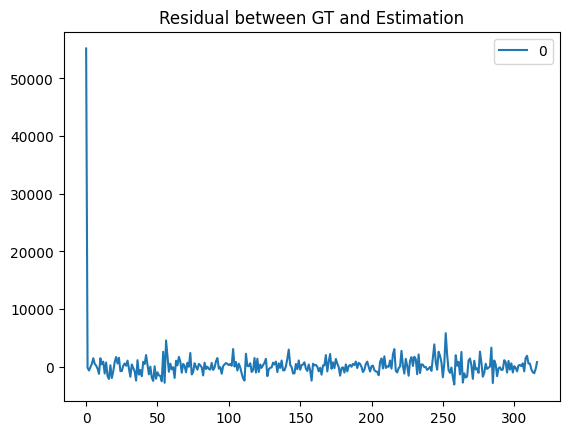

In [7]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = "Residual between GT and Estimation")

In [9]:
forecast_data = model_fit.forecast(steps=5)

In [8]:
# *-- 실제 데이터 확인 --*
forecasts = yf.download('005930.KS',
                     start='2021-12-01',
                     end='2021-12-10')
print(forecasts['Close'].values)

[*********************100%%**********************]  1 of 1 completed

[74400. 75800. 75600. 76300. 77400. 77400. 78200.]


In [12]:
#ADF(Augmented Dickey-Fuller) Test 실행
result = adfuller(samsung_train_df['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.172596
p-value: 0.941710
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [13]:
#KPSS test 진행
result = kpss(samsung_train_df['price'], regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.081719
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-13-2fc4b3250e33>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(samsung_train_df['price'], regression='c')


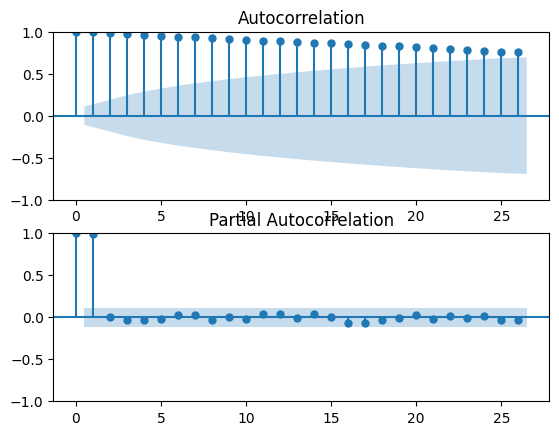

In [14]:
#ACF, PACF 플롯 생성
fig, ax = plt.subplots(2,1)
plot_acf(samsung_train_df['price'], ax=ax[0])
plot_pacf(samsung_train_df['price'], ax=ax[1])
plt.show()

In [15]:
# auto_arima를 사용하여 최적의 ARIMA 모델 찾기
model = auto_arima(samsung_train_df['price'], start_p=0, start_q=0,
                   test='adf',       # 사용할 정상성 검사 방법
                   max_p=3, max_q=3, # 최대 p, q 값
                   m=1,              # 계절성 주기
                   d=None,           # 차분 차수
                   seasonal=False,   # 계절성 모델 사용 여부
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5396.942, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5398.870, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5398.888, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5396.676, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5400.883, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.529 seconds


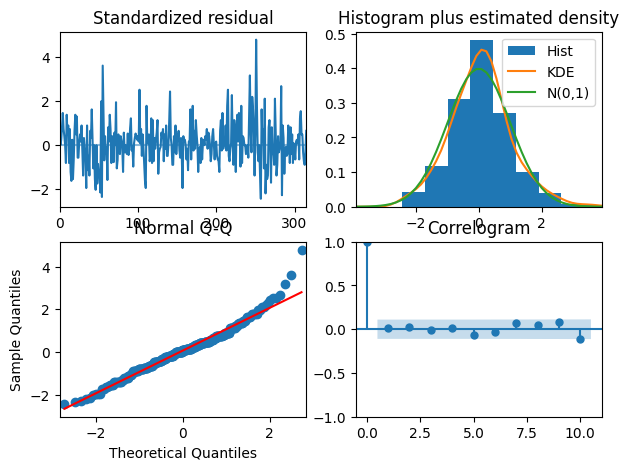

In [16]:
# 진단
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [17]:
# 예측
forecast = model.predict(n_periods=len(samsung_test_df))
forecast = pd.DataFrame(forecast, index = samsung_test_df.index, columns=['Prediction'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


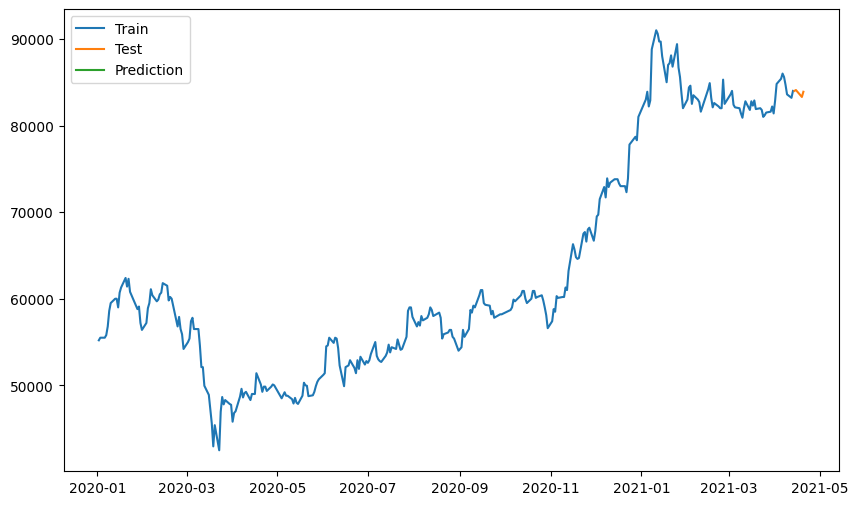

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(samsung_train_df.index, samsung_train_df['price'], label='Train')
plt.plot(samsung_test_df.index, samsung_test_df['price'], label='Test')
plt.plot(forecast.index, forecast['Prediction'], label='Prediction')
plt.legend()
plt.show()